# <a id='toc1_'></a>[Ten Minutes Testing New Features](#toc0_)

> Integrating Multi-Chain MCMC and Arviz Functionality into the HDDM

As is well known, the HDDM itself does not support fitting multiple chains in MCMC, so fitting an HDDM model with multiple chains requires users to perform complex customization. In addition, the Bayesian plotting and testing capabilities included in HDDM are relatively rudimentary, and leveraging arviz (based on xarray's InferenceData) can help users perform more flexible post-analysis.

Previous work in our laboratory, [dockerHDDM](https://github.com/hcp4715/dockerHDDM), has implemented multiple-chain MCMC fitting and conversion of hddm models to arviz InferenceData. However, these methods have not been well integrated into the modules on which hddm itself depends. This work ported these features to the core dependency library of hddm, `kabuki`, which fundamentally solves the problems that existed before and makes it more convenient for users to use.

We hope that this notebook can provides a good example of how to use our advanced update to run multiple chains in parallel and generate an ArViz InferenceData from the hddm class.

Firstly, ensure that you are operating within the dockerHDDM environment. Should you find yourself in a local Python or Conda environment rather than the dockerHDDM, which comes pre-installed with the official HDDM, please proceed to remove the original Kabuki package and install our development version from github at https://github.com/panwanke/kabuki, which is compatible with hddm >= 0.8.0.
To ensure that all functions properly, we recommend using our HDDM development version at https://github.com/panwanke/hddm. 


```
!pip uninstall kabuki -y
!pip install git+https://github.com/panwanke/kabuki
!pip uninstall hddm -y
!pip install git+https://github.com/panwanke/hddm
```

And you could see the development version is kabuki 0.6.5RC3 and hddm 0.9.8RC. 

**Table of contents**<a id='toc0_'></a>    
- [Ten Minutes Testing New Features](#toc1_)    
    - [Basic Bayesian hierarchical model](#toc1_1_1_)    
    - [HDDM with regressors](#toc1_1_2_)    
    - [model comparison with LOO](#toc1_1_3_)    
  - [statistical inference](#toc1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=RuntimeWarning)

import hddm
import kabuki
import arviz as az

print("The current version of kabuki is: ", kabuki.__version__)
print("The current version of HDDM is: ", hddm.__version__)
print("The current version of arviz is: ", az.__version__)

The current version of kabuki is:  0.6.5RC4
The current version of HDDM is:  1.0.1RC
The current version of arviz is:  0.15.1


Loading the data from the hddm package

In [3]:
data = hddm.load_csv(hddm.__path__[0] + "/examples/cavanagh_theta_nn.csv")
data = data[data['subj_idx'].isin([0,1,2,3,4])]
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


Sampling a basic model to ensure that the python enviroment is working properly. 

In [4]:
model = hddm.HDDM(data, include = ['v', 'a', 't', 'z'])
model.sample(100)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 100 of 100 complete in 1.6 sechddm sampling elpased time:  1.674 s


### <a id='toc1_1_1_'></a>[Basic Bayesian hierarchical model](#toc0_)

Now, let we **run the model with 4 chains in parallel**, and **return the ArViz InferenceData**.

In [5]:
%time
model0 = hddm.HDDM(data, include = ['v', 'a', 't', 'z'])
# note: when chains more than one, sampling process will be run parallelly, and the tmp_*.db will be saved in the current directory
model0_infdata = model0.sample(500, chains = 4, return_infdata = True)
model0_infdata

No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


[--                6%                  ] 31 of 500 complete in 0.5 sec
[--                6%                  ] 30 of 500 complete in 0.5 sec
[--                6%                  ] 30 of 500 complete in 0.5 sec
[--                5%                  ] 29 of 500 complete in 0.5 sec
[----             12%                  ] 60 of 500 complete in 1.0 sec
[----             11%                  ] 59 of 500 complete in 1.0 sec
[----             11%                  ] 57 of 500 complete in 1.0 sec
[----             11%                  ] 57 of 500 complete in 1.0 sec
[------           17%                  ] 87 of 500 complete in 1.5 sec
[------           17%                  ] 87 of 500 complete in 1.5 sec
[------           16%                  ] 83 of 500 complete in 1.5 sec
[------           16%                  ] 84 of 500 complete in 1.5 sec
[--------         23%                  ] 116 of 500 complete in 2.0 sec
[--------         23%                  ] 115 of 500 complete in 2.0 sec
[---

Inference data with groups:
	> posterior
	> observed_data

Then we used the arviz to diagnose the model. 

We can obtain the Rhat, ess, and other diagnostic for each parameter.

In [6]:
az.summary(model0_infdata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.910,0.240,1.471,2.364,0.006,0.004,1584.0,1192.0,1.00
a_std,0.516,0.274,0.197,0.976,0.011,0.008,751.0,721.0,1.00
a_subj.0,2.199,0.066,2.074,2.316,0.002,0.001,1062.0,1490.0,1.00
a_subj.1,2.123,0.067,1.993,2.245,0.002,0.002,783.0,1040.0,1.00
a_subj.2,1.553,0.047,1.461,1.637,0.001,0.001,1095.0,1225.0,1.00
a_subj.3,2.158,0.076,2.027,2.309,0.003,0.002,664.0,965.0,1.01
a_subj.4,1.484,0.050,1.387,1.576,0.002,0.001,708.0,1084.0,1.00
v,0.530,0.291,0.005,1.088,0.006,0.005,2026.0,1565.0,1.00
v_std,0.576,0.311,0.183,1.138,0.013,0.009,622.0,927.0,1.00
v_subj.0,0.134,0.067,0.012,0.247,0.003,0.002,475.0,1055.0,1.01


We could also plot the traceplot and posterior distribution for each parameter to check the convergence of the model.

Note: different chains are plotted in different colors.

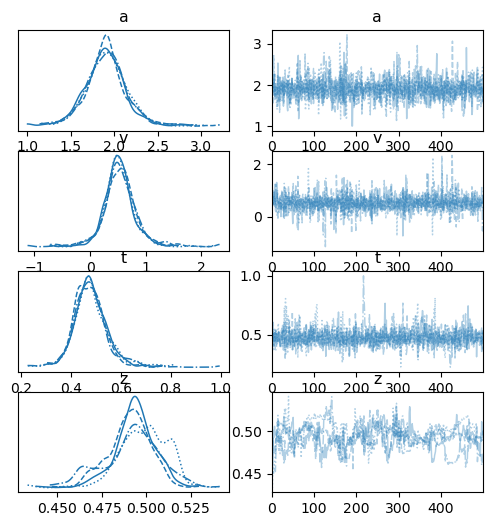

In [7]:
fig = az.plot_trace(model0_infdata, var_names = ['a', 'v', 't', 'z'], figsize = (6,6))

### <a id='toc1_1_2_'></a>[HDDM with regressors](#toc0_)

Next, we will try a more complex model, such as hddm with regressors. 
- In this example, we assume that the decision boundary varies with the condition `conf` and set the `LC` condition as a reference, so that the `v` coefficient represents the difference between LC and HC. 
- We show how to save a model to an arbitrary directory using the `save_name` argument. 
- `sample_prior` allow to sample draws from prior distribution, and then used to calculate Bayes Factor (BF). 
- To enable model comparison, we have added the `loglike = True` argument to calculate the pointwise log likelihood of the model, which can be further used for calculating WAIC and LOOIC. 
- Additionally, we have added the `ppc = True` argument, which allows us to generate posterior predictive checks for the model."

In [3]:
%time
model_reg = hddm.HDDMRegressor(data, "v ~ 1 + C(conf, Treatment('LC'))",include = ['v', 'a', 't', 'z'])
# note: setting save_name argument will delete the _temp*.db file
save_name = "model_fitted/hddmregressor_example"
model_reg_infdata = model_reg.sample(
    500, chains = 4, 
    return_infdata = True, save_name = save_name, 
    sample_prior = True, loglike = True, ppc = True)

No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


[                  1%                  ] 7 of 500 complete in 0.5 sec
[                  1%                  ] 7 of 500 complete in 0.5 sec
[                  1%                  ] 8 of 500 complete in 0.6 sec
[                  1%                  ] 8 of 500 complete in 0.6 sec
[-                 3%                  ] 16 of 500 complete in 1.1 sec
[-                 3%                  ] 15 of 500 complete in 1.0 sec
[-                 3%                  ] 16 of 500 complete in 1.1 sec
[-                 3%                  ] 16 of 500 complete in 1.1 sec
[-                 4%                  ] 24 of 500 complete in 1.6 sec
[-                 4%                  ] 23 of 500 complete in 1.5 sec
[-                 4%                  ] 23 of 500 complete in 1.7 sec
[-                 4%                  ] 24 of 500 complete in 1.6 sec
[--                6%                  ] 31 of 500 complete in 2.2 sec
[--                6%                  ] 30 of 500 complete in 2.1 sec
[--       

In [4]:
model_reg_infdata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> prior
	> observed_data

We can see the InfData consist of five parts, including the prior, posterior, posterior_predictive, log_likelhood, and observed_data.

When you set the 'save_name' argument to a `str` of the desired file path, hddm will save the model to two files in that location: the model itself (e.g. `hddmregressor_example.hddm`) and the trace of the model (`hddmregressor_example.db`). 

Additionally, if you use the argument `return_infdata = True`, it convert the hddm model to ArViz InferenceData, the InferenceData will also be saved to the same path (`hddmregressor_example.nc`).

As a result, we can easily load the model and InferenceData using the following code:

In [10]:
%time
save_name = "model_fitted/hddmregressor_example"
# loading the inference data is faster than loading the origin hddm class
# model_reg = hddm.load(save_name + ".hddm")
model_reg_infdata = az.from_netcdf(save_name + ".nc")

CPU times: user 3.03 s, sys: 256 ms, total: 3.28 s
Wall time: 3.28 s


Then we can use the InferenceData to calculate WAIC and LOOIC.

In [11]:
%time
hddm_reg_LOO = az.loo(model_reg_infdata)
hddm_reg_LOO

CPU times: user 952 ms, sys: 3.47 ms, total: 955 ms
Wall time: 954 ms


Computed from 2000 posterior samples and 1427 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3818.90   884.58
p_loo     2012.18        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1408   98.7%
 (0.5, 0.7]   (ok)          3    0.2%
   (0.7, 1]   (bad)         1    0.1%
   (1, Inf)   (very bad)   15    1.1%

### <a id='toc1_1_3_'></a>[model comparison with LOO](#toc0_)

To determine if the task condition `conf` affects the drift rate. We can compare `model0` and `model_reg` to test the effect of conf on the drift rate.

We can use the `az.compare` function to compare the two models.

In [12]:
%time
# To compare models by loo or waic, we should make sure 
# that the pointwise log-likelihood is calculated. 
# Another way is to use to_infdata methods with loglike=True,
# but ensure that the 'tmp_*.db' file for each chain is in the current directory 
model0_infdata = model0.to_infdata(loglike=True)

compare_dict = {
    "model0(baseline)": model0_infdata, 
    "model_reg(v ~ conf)": model_reg_infdata}
az.compare(compare_dict, ic="waic")

Start converting to InferenceData...
Start to calculate pointwise log likelihood...
The time of calculation of loglikelihood took 5.997 seconds
CPU times: user 3.16 s, sys: 72.6 ms, total: 3.23 s
Wall time: 6.88 s


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model0(baseline),0,-12366.847830,10529.831055,0.000000,0.5,5628.680090,0.000000,True,log
model_reg(v ~ conf),1,-13118.118858,11311.400172,751.271028,0.5,5976.425112,1131.441842,True,log


We can see that the model with varing of drift rate get higher elpd value that indicate it is better than the baseline model. 

Futhermore, we can plot the posterior predictive checks to check the best model.

The below code show how to plot the ppc for each subject like the hddm's `plot_posterior_predictive` (e.g. `model_reg.plot_posterior_predictive(figsize=(14, 10))`)

More examples see [dockerHDDM_Workflow](./dockerHDDM_Workflow.ipynb)

array([<AxesSubplot: xlabel='rt / rt\n0'>,
       <AxesSubplot: xlabel='rt / rt\n1'>,
       <AxesSubplot: xlabel='rt / rt\n2'>,
       <AxesSubplot: xlabel='rt / rt\n3'>], dtype=object)

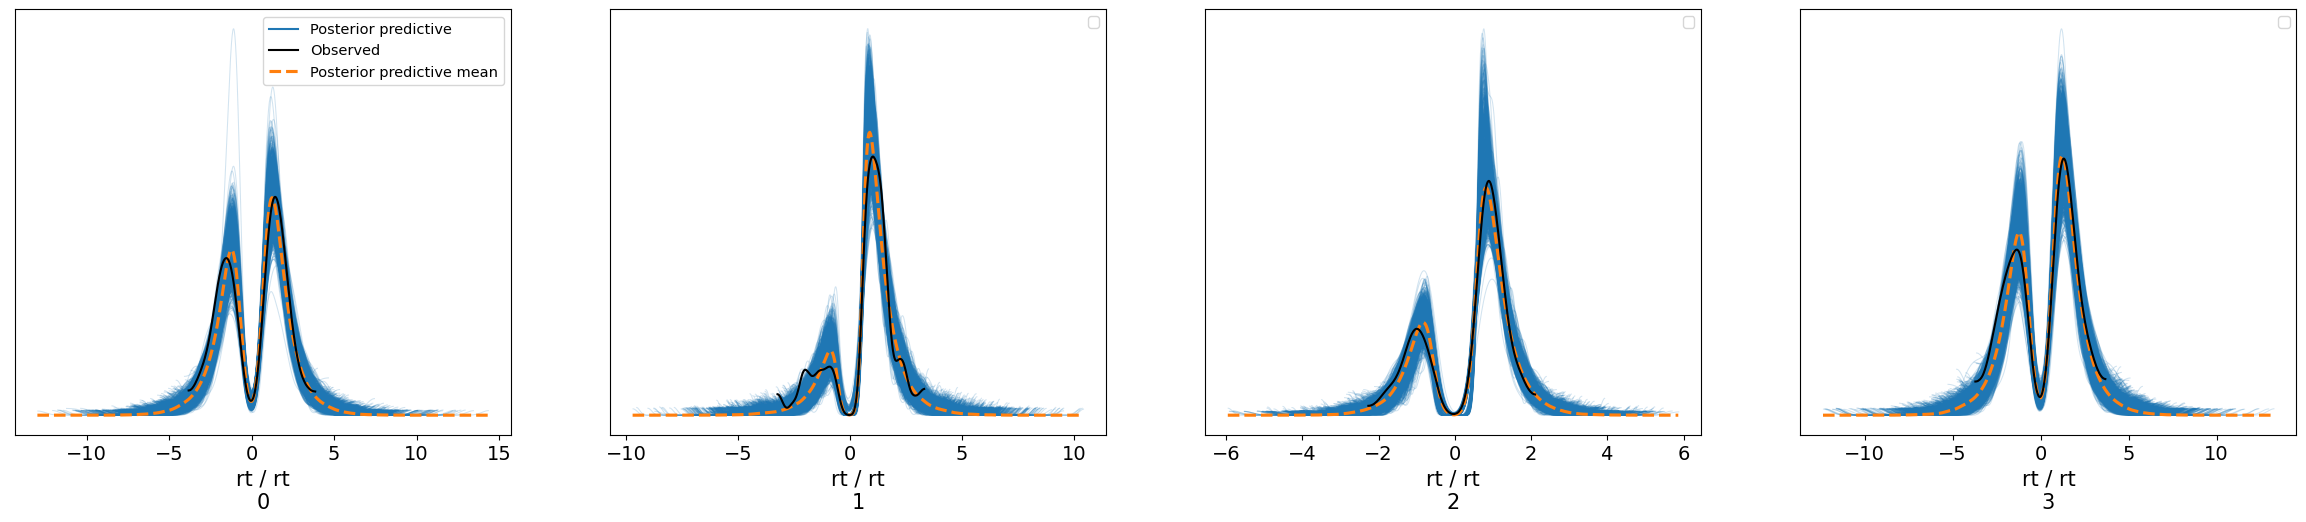

In [13]:
model_reg_infdata = model_reg_infdata.assign_coords(
  obs_id=model_reg_infdata.observed_data.coords['subj_idx'].values, 
  groups="observed_vars")

az.plot_ppc(model_reg_infdata, var_names= 'rt', coords={'obs_id': [0, 1, 2, 3]}, flatten=[])

## <a id='toc1_2_'></a>[statistical inference](#toc0_)

Finally, statistical inferences are made from the parameter posterior distributions of the optimal model, i.e., the effect of conf on drift rate `v`.

Using `az.plot_posterior()`, we can plot the parameter posterior distributions as well as display statistics related to the posterior distributions.

Note that by setting the RPOE (region of practical equivalence) we assume that the difference in `v` between the two conditions (LC vs. HC) ranges from -0.2 to 0.2. If the 95% HDI of the posterior distribution of the regression coefficients (LC - HC) exceeds this range, we make a plausible inference of difference.

In this example, the 95% HDI of the posterior distribution of the regression coefficients for the regression of `v` less than 0 and the lower ROPE boundary -0.2. 
Therefore, we make the inference that there is sufficient evidence of an effect of the conflict level on the rate of evidence accumulation.

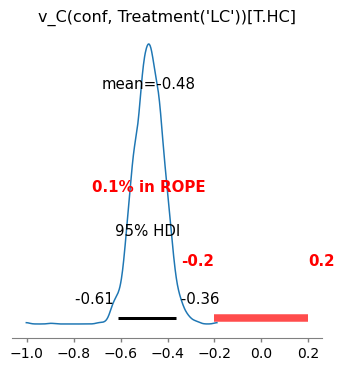

In [5]:
ax = az.plot_posterior(
    model_reg_infdata, var_names = "v_C(conf, Treatment('LC'))[T.HC]", 
    hdi_prob=0.95, rope = [-0.2,0.2], rope_color="r",
    figsize = (4,4)
)

The reference value is outside of the posterior. This translate into infinite support for H1, which is most likely an overstatement.


(-1.0, 0.5)

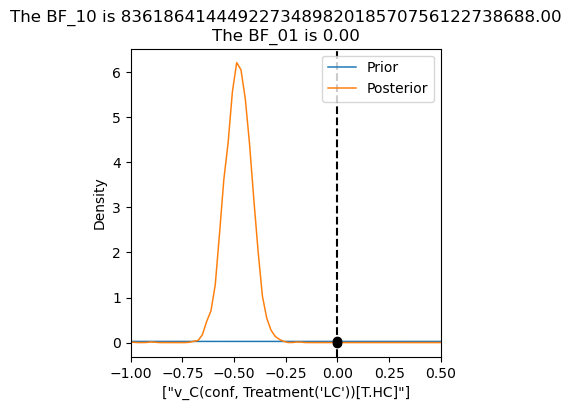

In [6]:
import matplotlib.pyplot as plt
ax = az.plot_bf(
    model_reg_infdata, 
    var_name=["v_C(conf, Treatment('LC'))[T.HC]"], 
    ref_val=0,
    figsize = (4,4)
)
plt.xlim(-1,0.5)

In conclusion, our contribution has three key benefits:
1. You now have the freedom to save the model to any desired path, even if it is not available in the original hddm.
2. Rather than generating separate db files for each chain (which could not be moved to other paths in the previous version), we now save all chains' db files in a single location of your choosing.
3. We provide a simple way to convert the hddm model to ArViz InferenceData, which allows you to calculate pointwise loglikelihood for model comparison (e.g. WAIC and LOOIC), and generate predictions for model checking (e.g. posterior predictive checks)."

Lastly, I hope you enjoy using this version as it will be beneficial to your modeling work.

If you have any questions, please contact me at [panwanke@163.com](panwanke@163.com) or commit an issue at [epool/kabuki](https://gitee.com/epool/kabuki/issues) ↗